# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-26")

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


"../data/count_lengths/run_2018-11-26"

# TODO:
- improved fig 4 aim 2 (just show a trend line and points, directly relating overall error to the specific error measure)
- improved fig 3 aim 1 (I dont' need the 1x for the 10^8)
- plots for early results (Fig 2-3)
- run buildup simulation
- run the sensitivity analyses
- run the factorial analysis
- power analysis for aim 2


# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [49]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
setfile = AuditoryBistabilityLE.read_settings(settings)
for_results_in(joinpath(datadir,"data")) do entry
  # with_logger(NullLogger()) do
  #     lengths, percepts = percept_lengths(audiospect(entry["mask"],setfile),params[entry["pindex"],:],setfile)
  #     push!(results,DataFrame(length=lengths,percepts=percepts.+1,created=entry["created"],pindex=entry["pindex"]))
  # end
  
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-26T17:38:30.128,1
2,23.3,1,2018-11-26T17:40:27.495,1
3,23.3,1,2018-11-26T17:40:30.437,1
4,23.3,1,2018-11-26T17:40:33.359,1
5,23.3,1,2018-11-26T17:40:36.249,1
6,23.3,1,2018-11-26T17:40:39.153,1


In [3]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

23.6

In [4]:
dfh = setup_human_data()

┌ Warning: Default for keyword argument "closed" has changed from :right to :left.
│ To avoid this warning, specify closed=:right or closed=:left as appropriate.
│   caller = #fit#99 at hist.jl:234 [inlined]
└ @ Core /Users/davidlittle/.julia/packages/StatsBase/NzjNi/src/hist.jl:234
┌ Warning: Default for keyword argument "closed" has changed from :right to :left.
│ To avoid this warning, specify closed=:right or closed=:left as appropriate.
│   caller = #fit#99 at hist.jl:234 [inlined]
└ @ Core /Users/davidlittle/.julia/packages/StatsBase/NzjNi/src/hist.jl:234


(stream = 3×6 DataFrame
│ Row │ st     │ mean     │ rms       │ lowerc   │ upperc   │ experiment │
│     │ Int64⍰ │ Float64  │ Float64   │ Float64  │ Float64  │ String     │
├─────┼────────┼──────────┼───────────┼──────────┼──────────┼────────────┤
│ 1   │ 3      │ 0.15     │ 0.0919608 │ 0.085787 │ 0.213611 │ human      │
│ 2   │ 6      │ 0.559259 │ 0.164846  │ 0.453688 │ 0.669784 │ human      │
│ 3   │ 12     │ 0.89321  │ 0.13448   │ 0.834552 │ 0.945679 │ human      │, lengths = (dens = [0.00207014, 0.00514879, 0.0195673, 0.0324123, 0.0389907, 0.0697291, 0.0, 0.0605115, 0.101965, 0.0  …  0.0, 0.0, 0.0, 0.0155482, 0.0, 0.0, 0.0, 0.0, 0.0170312, 0.0], err = 0.10330189613996829))

In [44]:
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(@where(params,:Δf .== 6),fields) do row
    next!(progress)
    result =
        model_rms(df,params,dfh,return_parts=true,N=1,
                  f_c_a=row[1,:f_c_a], f_c_m=row[1,:f_c_m], f_c_σ = row[1,:f_c_σ],
                  s_c_a=row[1,:s_c_a], s_c_m=row[1,:s_c_m], s_c_σ = row[1,:s_c_σ],
                  t_c_a=row[1,:t_c_a], t_c_m=row[1,:t_c_m], t_c_σ = row[1,:t_c_σ])
    DataFrame([result])
end

dfplot = @linq df_summary |>
    rename_levels_for([:rms, :stream_rms, :stream_mratio, :length_rms, :stream_sd, :length_sd]) |>
    transform(a = pack(:c_a), m = packaxes(:c_m), stream_ratio = :stream_rms ./ (:stream_rms .+ :length_rms)) |>
    transform(rms_str = fmt.("01.2f",:rms),
              length_rms_str = fmt.("01.2f",:length_rms),
              stream_rms_str = fmt.("01.2f",:stream_rms),
              stream_ratio_str = fmt.("01.2f",:stream_ratio),
              stream_mratio_str = fmt.("01.2f",:stream_mratio))
              
head(dfplot)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


,c_m,c_a,level,rms,stream_rms,stream_mratio,length_rms,stream_sd,length_sd,a,m,stream_ratio,rms_str,length_rms_str,stream_rms_str,stream_ratio_str,stream_mratio_str
,Float64,Float64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,String,String,String,String
1,0.0,0.0,Peripheral,2.32752,4.33658,1.3303,0.318466,0.0395166,4.20066e-16,0.0,0.0,0.931587,2.33,0.32,4.34,0.93,1.33
2,5.0,0.0,Peripheral,1.53628,2.42871,2.84982,0.643858,0.122515,1.5325,0.0,1.5,0.79045,1.54,0.64,2.43,0.79,2.85
3,15.0,0.0,Peripheral,1.34097,1.9729,0.503531,0.70904,0.337336,1.86743,0.0,2.5,0.735624,1.34,0.71,1.97,0.74,0.50
4,44.0,0.0,Peripheral,1.58255,2.01059,0.662181,1.1545,0.135648,0.0,0.0,3.5,0.635239,1.58,1.15,2.01,0.64,0.66
5,130.0,0.0,Peripheral,1.57441,1.99432,0.778105,1.1545,0.0732337,0.0,0.0,4.5,0.633354,1.57,1.15,1.99,0.63,0.78
6,390.0,0.0,Peripheral,1.57241,1.99031,0.778333,1.1545,0.0692439,0.0,0.0,5.5,0.632887,1.57,1.15,1.99,0.63,0.78


In [9]:
scale = reverse!(colormap("RdBu",mid=(1.5-0.5)/1.5));
function bluered(;minvalue,maxvalue,colorstart=minvalue,colorstop=maxvalue,midvalue=(colorstop-colorstart)/2+colorstart)
    scale(x,min,max) = (x - min)/(max - min)
    scalei(x,min,max) = x*(max - min) + min
    fi(x) = scalei(x,minvalue,maxvalue)
    c(x) = scale(x,colorstart,colorstop)
    colors = reverse!(colormap("RdBu",mid=1-c(midvalue)))
    
    function(x)
        colors[1+clamp(floor(Int,99*c(fi(x))),0,99)]
    end
end

bluered (generic function with 1 method)

In [11]:
xvals = sort!(unique(dfplot.a));
yvals = sort!(unique(dfplot.m));

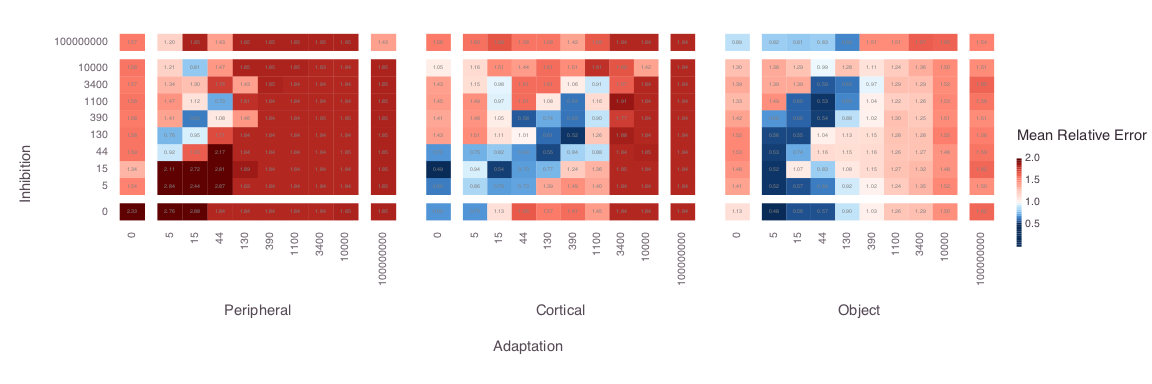

false

In [73]:
pl = plot(dfplot,x=:a,y=:m,color=:rms,xgroup=:level,label=:rms_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Scale.x_continuous(labels=string ∘ Int ∘ packinvfn(dfplot.c_a)),
                       Scale.y_continuous(labels=string ∘ Int ∘ packinvfn(dfplot.c_m)),
                       Guide.xticks(ticks=xvals,orientation=:vertical),
                       Guide.yticks(ticks=yvals,orientation=:horizontal)),
     Guide.xlabel("Adaptation"), Guide.ylabel("Inhibition"),
     Scale.color_continuous(minvalue=0,maxvalue=2,colormap=bluered(minvalue=0,maxvalue=2,colorstart=0.5,midvalue=1.0)),
     Guide.colorkey(title="Mean Relative Error"),
     Theme(grid_line_width=0inch,point_label_font_size=4pt,point_label_color=colorant"gray"))
draw(PDF(joinpath(grantdir,"fig3A.pdf"),9inch,3.5inch),pl)
draw(PNG(12inch,4inch),pl)

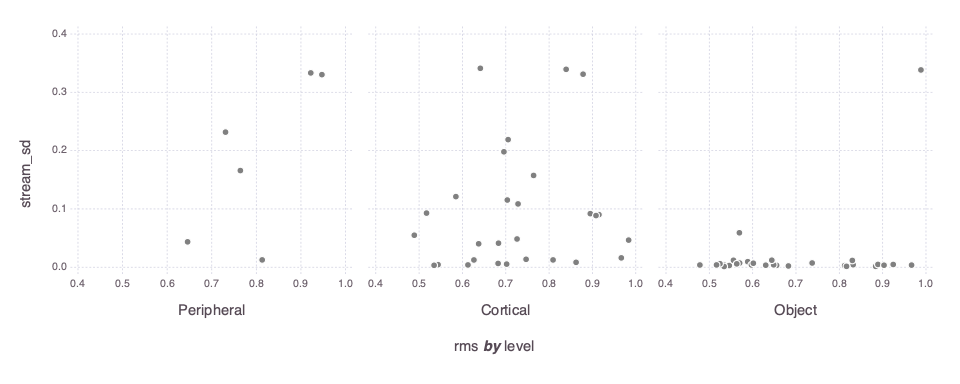

false

In [45]:
pl = plot(@where(dfplot,:rms .<= 1),x=:rms,y=:stream_sd,xgroup=:level,
    Geom.subplot_grid(Geom.point,Scale.y_continuous(labels=x -> fmt("1.1f",x))),
    Theme(default_color="gray"))
draw(PDF(joinpath(grantdir,"fig4A.pdf"),7.5inch,3inch),pl)
draw(PNG(10inch,4inch),pl)

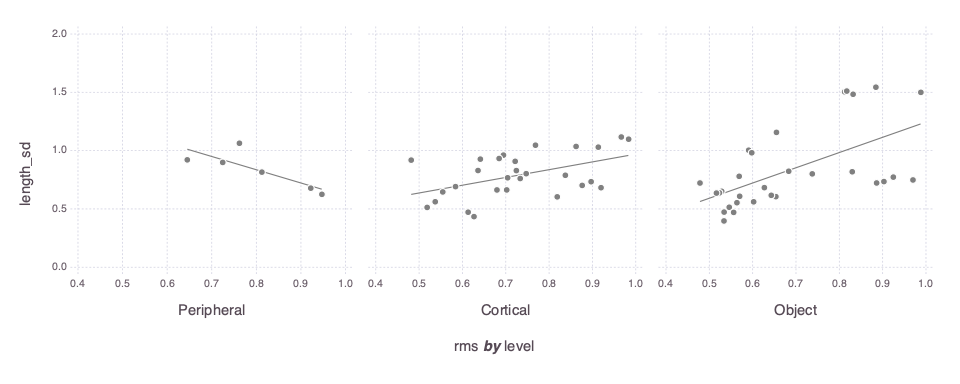

false

In [38]:
pl = plot(@where(dfplot,:rms .< 1.0),x=:rms,y=:length_sd,xgroup=:level,Geom.subplot_grid(Geom.point,Geom.smooth(method=:lm)),Theme(default_color="gray"))
draw(PDF(joinpath(grantdir,"fig4B.pdf"),7.5inch,3inch),pl)
draw(PNG(10inch,4inch),pl)

In [89]:
R"""
library(dplyr)
df = $dfplot %>% filter(rms < 1)
model = lm(length_sd ~ rms*level,df)
print(anova(model))
summary(model)
"""

Analysis of Variance Table

Response: length_sd
          Df  Sum Sq Mean Sq F value    Pr(>F)    
rms        1 1.01846 1.01846 19.5030 4.443e-05 ***
level      2 0.12668 0.06334  1.2130   0.30474    
rms:level  2 0.42961 0.21481  4.1135   0.02135 *  
Residuals 58 3.02879 0.05222                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


RObject{VecSxp}

Call:
lm(formula = length_sd ~ rms * level, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.45621 -0.16154 -0.02058  0.15916  0.50312 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)           0.3054     0.2337   1.307   0.1965  
rms                   0.6623     0.3141   2.109   0.0393 *
levelObject          -0.3728     0.3017  -1.236   0.2215  
levelPeripheral       1.4595     0.7593   1.922   0.0595 .
rms:levelObject       0.6517     0.4151   1.570   0.1219  
rms:levelPeripheral  -1.8195     0.9438  -1.928   0.0588 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2285 on 58 degrees of freedom
Multiple R-squared:  0.3421,	Adjusted R-squared:  0.2854 
F-statistic: 6.031 on 5 and 58 DF,  p-value: 0.0001468



# Best model

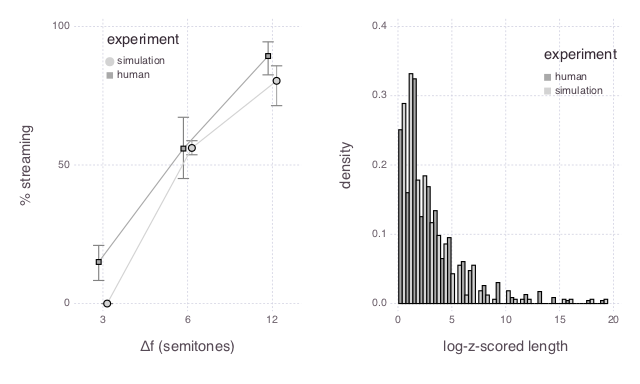

false

In [65]:
p = plot_fit(df,params,t_c_a=5,t_c_m=5)
draw(PDF(joinpath(grantdir,"fig2bc.pdf"),5inch,3inch),p)
draw(PNG(6.666inch,4inch),p)

# Peripheral-level

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/.julia/packages/ShammaModel/YlrBX/src/audiospect.jl:146


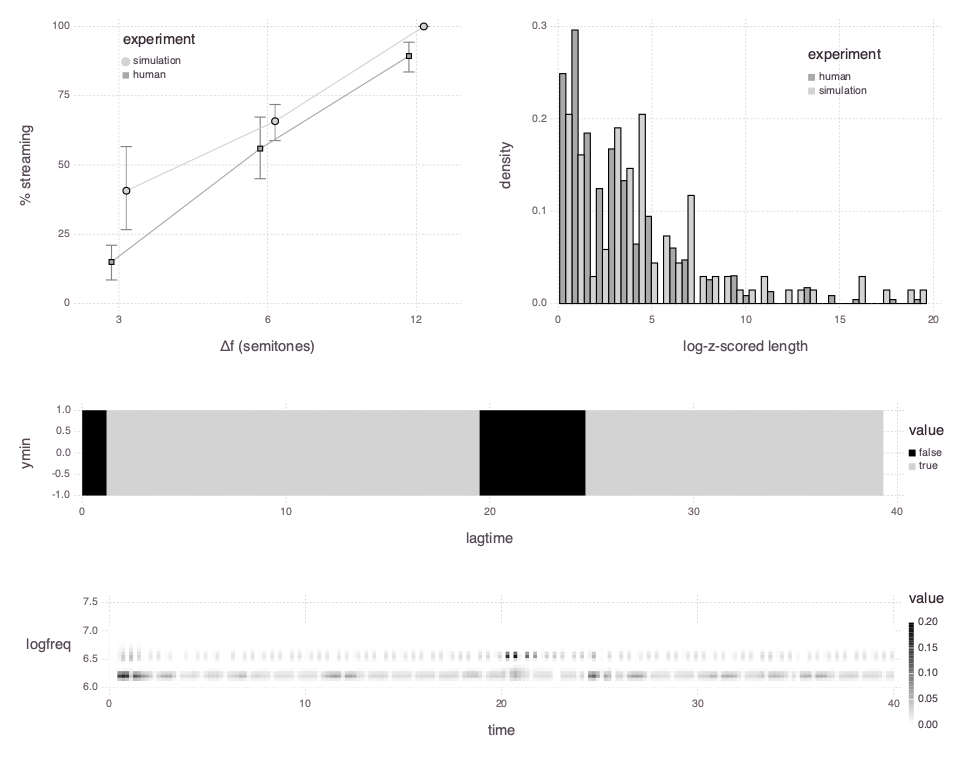

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/gUoMc/src/stim.jl:43


false

In [315]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=15,f_c_m=390,simulation=7,stop_time=40s))

possible claim: selectivity and bistability disappears, strong "bias" or basically a single percept shown
this will show up as
- bad streaming rms
- bad lengths rms
- poor match between mean and individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


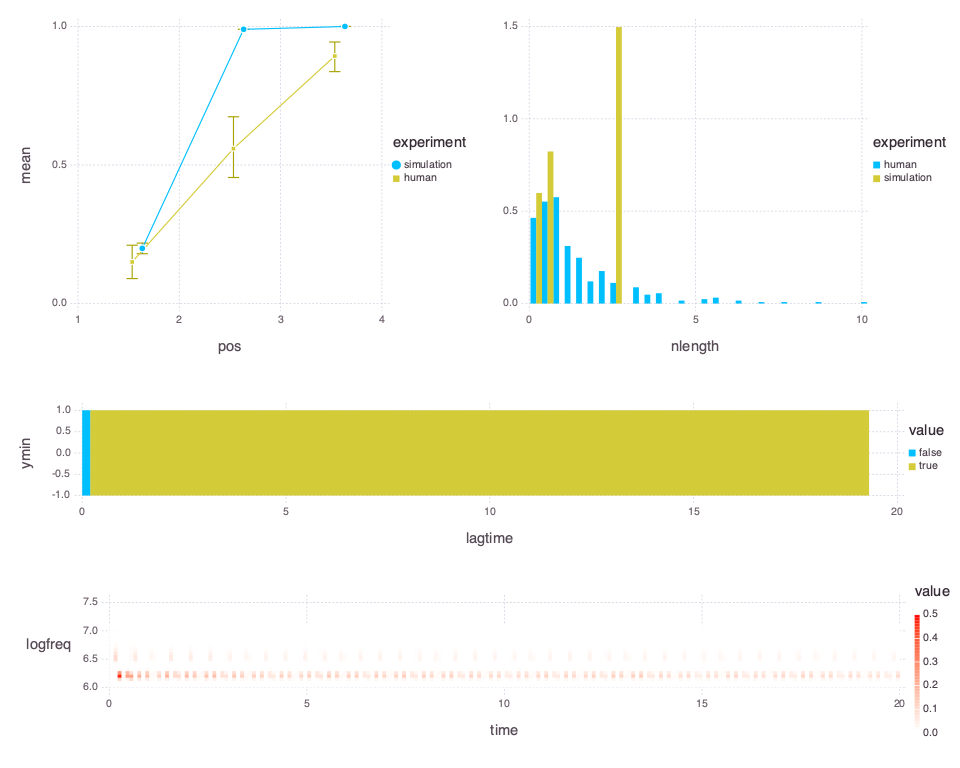

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [188]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=5,f_c_m=385))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


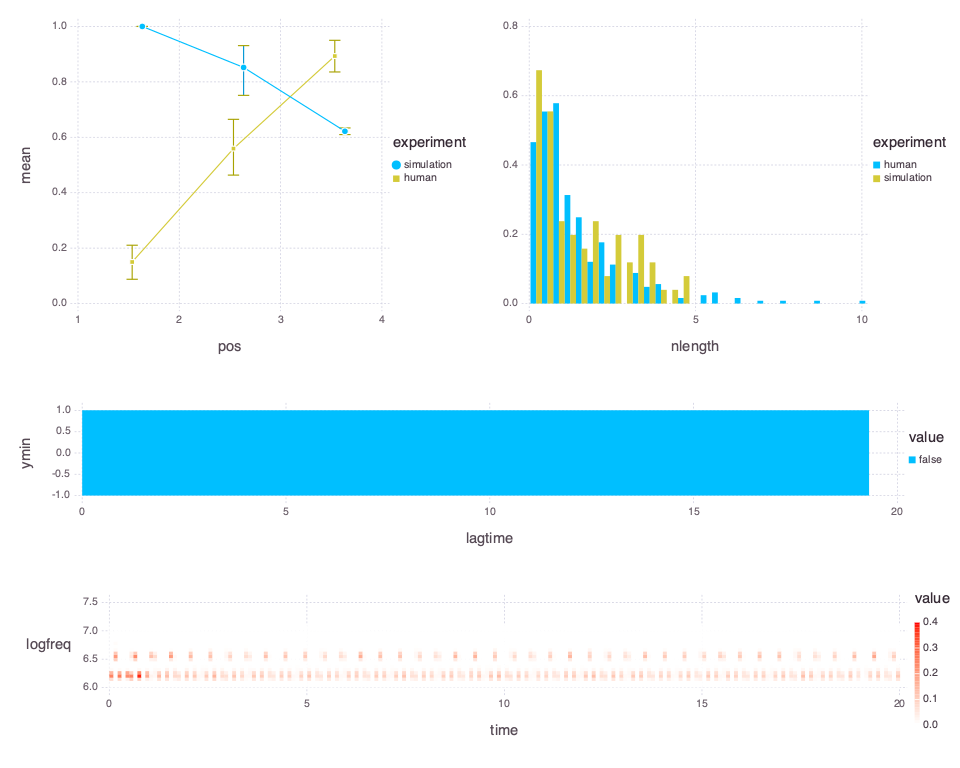

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [189]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=44,f_c_m=44))

# Cortical-level

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/.julia/packages/ShammaModel/YlrBX/src/audiospect.jl:146


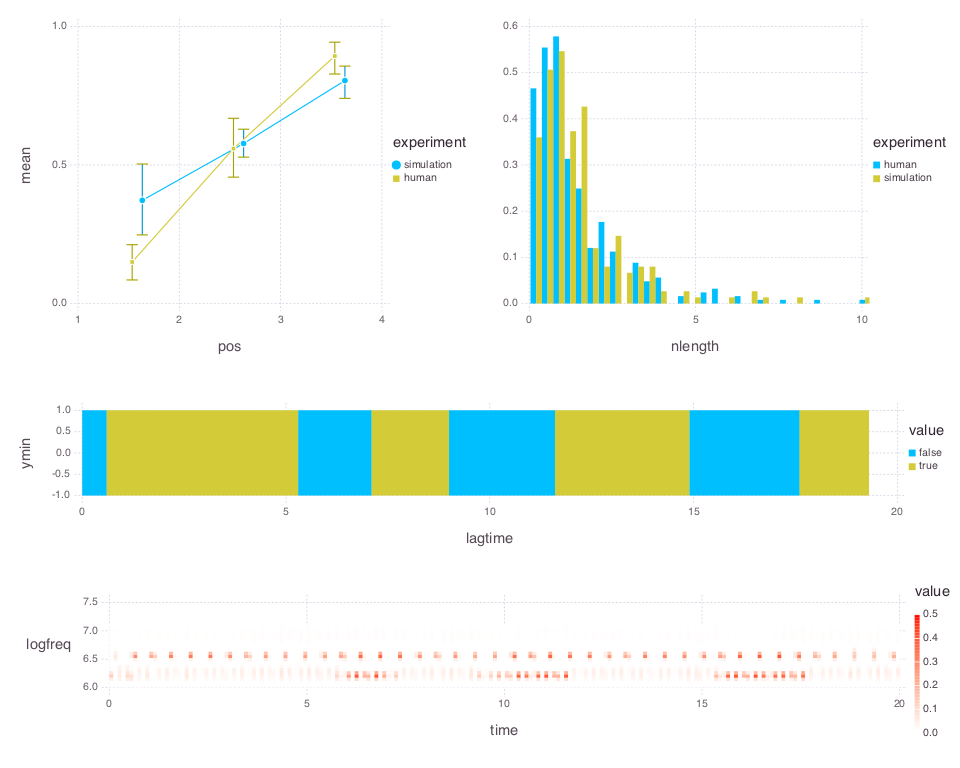

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/gUoMc/src/stim.jl:43


false

In [20]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=5,s_c_m=29))

In [266]:
stream_rms(df,params,stream_dfh(),s_c_a=130,s_c_m=15,mean_v_ind=true)

(1.8388431724488226, 1.6210451699346744)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/.julia/packages/ShammaModel/YlrBX/src/audiospect.jl:146


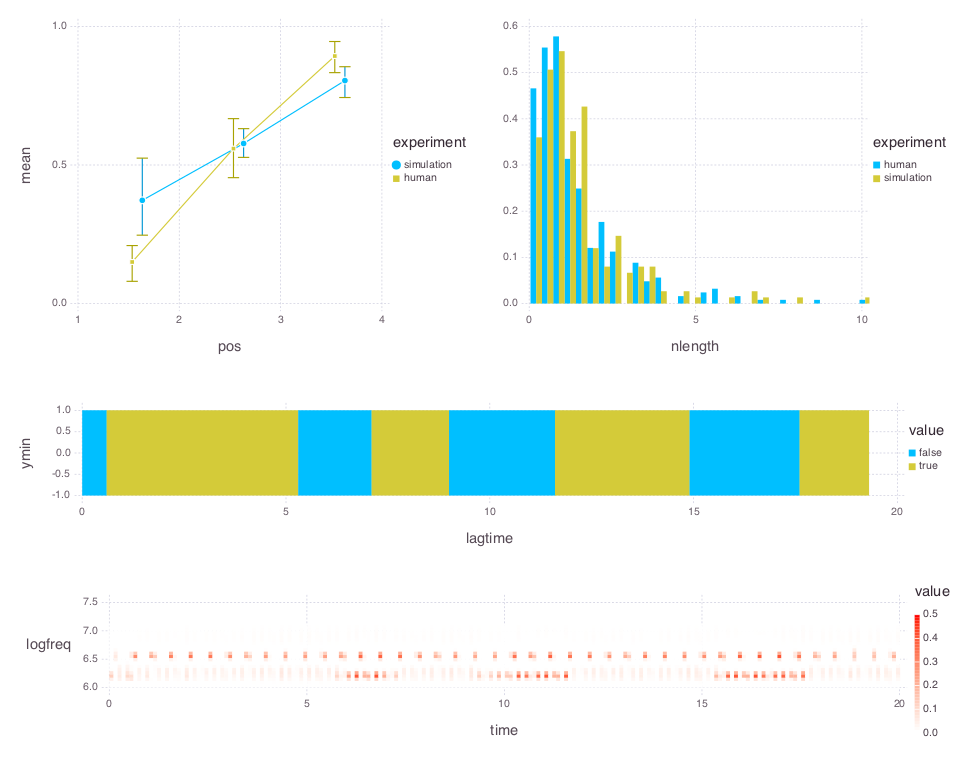

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/gUoMc/src/stim.jl:43


false

In [24]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=5,s_c_m=29))

In [4]:
stream_rms(df,params,stream_dfh(),s_c_a=5,s_c_m=130,mean_v_ind=true)

(2.2816584377854863, 3.47184038055728)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


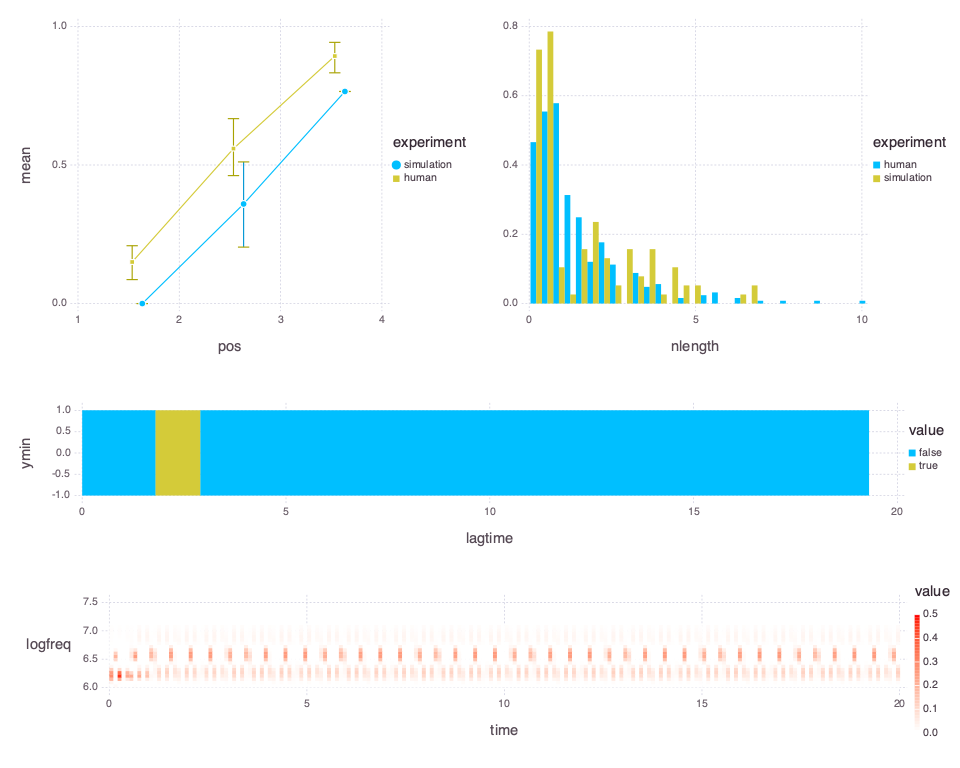

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [192]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=5,s_c_m=130))

# Object-level

In [ ]:
possible claim: bistability remains, selectivity reduced at offset values

- poor streaming rms
- good length rms
- good match of mean to individual rms

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


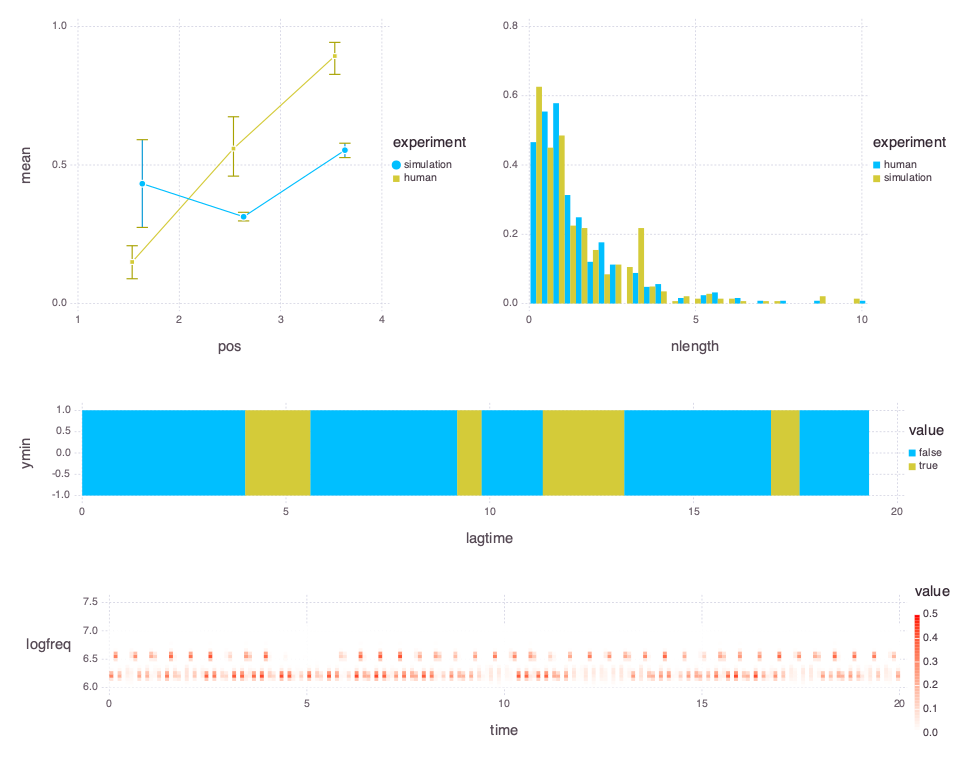

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [195]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=1141,t_c_m=1141))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


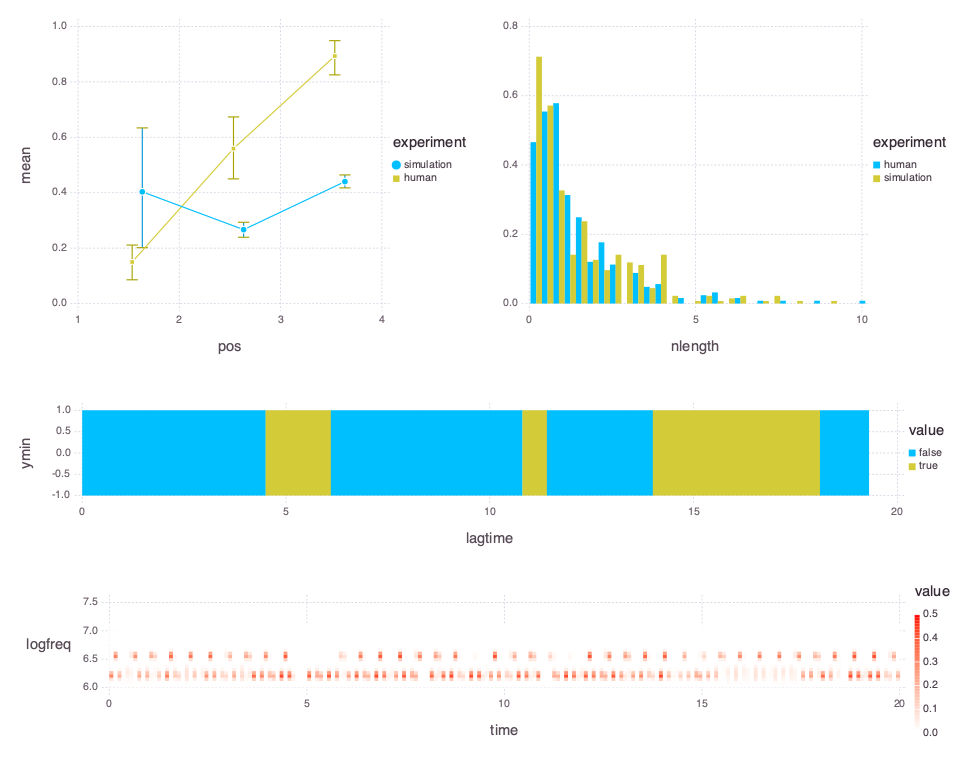

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [197]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=10000,t_c_m=5))

# Count

In [ ]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

In [ ]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Thoughts

This is interesting; the variance in the human data is greater (might suggest multiple sources, consistnet with earlier reports).

That said, it is really distracting from the point I'm trying to caputre at this stage of the analysis. I can image this plot going somewhere else... OR
normalizing by the variance in some way, so that we can determine the extent to which we can match that... for the moment that seems like a reasonable standard.

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

In [ ]:
using PlotAxes

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s],audiospect_stimulus(params[selection,:],settings)[10s .. 30s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 32) .< 1) .& (abs.(:s_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s],audiospect_stimulus(params[selection,:],settings)[25s .. 35s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20))

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [ ]:
@where(df,:pindex .== selection)

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.primary_source)

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
freqs(result.input[:,400Hz .. 1.2kHz])

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 3
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 12
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)